## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста, когда-то проходившего у меня. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

1. Дизайн эксперимента
   Гипотезы:
   H0 : p = p0 -  коэффициенты конверсии между новым и старым вариантами равны
   H : p != p0 - коэффициенты конверсии между новым и старым вариантами не равны

   Доверительный интервал - 95%
   Уровень доверия: 1 - 0.95 = 0.05

   Группа - Control - сервис standard
   Группа - Treatment - сервис svm_ensemble_v_1_22

In [3]:
# Импорт библиотек
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil


In [4]:
# Считаем размер эффекта
effect_size = sms.proportion_effectsize(0.13, 0.15)
effect_size

-0.0576728617308947

In [5]:
# Cчитаем необходимый размер выборки
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)
required_n

4719.4740575998185

In [6]:
# Округляем до ближайшего целого
required_n = ceil(required_n)
print("Для каждой группы нам необходимо не меньше ",required_n, " наблюдений")

Для каждой группы нам необходимо не меньше  4720  наблюдений


2. Сбор данных и их подготовка
   

In [8]:
df = pd.read_csv('D:/HW/2/module_2/practical_task/ab_test_inference/ab_test_ensembles.csv')
df.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
6,aa9d93c5-a18f-444a-a522-7e7145835362,2022-05-19 03:26:46.940749,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,registered_user
7,de214e30-9b8d-44cf-87b1-16917f3e1c89,2022-05-17 01:48:29.539573,control,standard,0,United Kingdom,18-25,registered_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [10]:
# Убедимся, что контрольная группа и испытуемая видят старую версию и новую
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [11]:
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [12]:
# отбор пользователей
control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state=42)
treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state=42)
control_sample
treatment_sample

,user_id,timestamp,group,variants,converted,location,age_group,user_type
187404,e1fbd883-eb6d-447c-8669-b78d916203bb,2022-05-03 05:26:18.171377,treatment,svm_ensemble_v_1_22,0,United Kingdom,34-41,new_user
265127,584ac43d-4742-43b6-b3ce-68e66242afc5,2022-05-23 16:32:37.952446,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
257560,af86dce8-d425-426d-9388-e28d3ee7e004,2022-05-16 07:45:15.673844,treatment,svm_ensemble_v_1_22,0,United Kingdom,34-41,registered_user
62508,98692f3c-61e5-407f-bbe5-622ce90e38d0,2022-05-14 23:36:34.272319,treatment,svm_ensemble_v_1_22,0,United Kingdom,34-41,registered_user
244185,5ffd7340-a85a-47fa-8759-1a2a9a93c6ea,2022-05-04 04:03:27.411971,treatment,svm_ensemble_v_1_22,0,United Kingdom,58+,new_user
...,...,...,...,...,...,...,...,...
248973,dd559005-fa95-4ba4-b259-5cb9d4955ef7,2022-05-15 16:06:35.931919,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,new_user
121457,67c748b9-8575-41ca-9e8f-06d8b8cfb650,2022-05-15 12:10:31.510014,treatment,svm_ensemble_v_1_22,1,United Kingdom,50-57,registered_user
140957,1a4ef263-c88c-4d7f-bc51-9f243d64484c,2022-05-15 14:34:30.073804,treatment,svm_ensemble_v_1_22,1,United Kingdom,34-41,registered_user
219249,755aa394-8d8b-462f-a8d0-9abd9919068e,2022-05-13 20:17:51.695845,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user


In [13]:
# Сформируем общую случайную выборку
ab_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_df.reset_index(drop=True, inplace=True)
ab_df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,bcf8452b-3056-4d45-994f-5f286fd9869a,2022-05-18 04:44:18.590293,control,standard,0,United Kingdom,42-49,new_user
1,3c827a98-0868-4ce5-ac31-8195e243af37,2022-05-14 05:22:43.771772,control,standard,0,United Kingdom,50-57,new_user
2,71c72bb9-13d9-4755-b398-b2c5d8b1c4d6,2022-05-23 08:52:53.050325,control,standard,0,United Kingdom,34-41,new_user
3,654ee878-b0c5-4223-b9fb-995ca3d2eaf1,2022-05-07 23:27:09.109877,control,standard,0,United Kingdom,26-33,registered_user
4,1e044366-7e86-4d92-bba7-3afaa6f887f8,2022-05-20 14:26:10.133979,control,standard,0,United Kingdom,42-49,new_user


In [14]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    9440 non-null   object
 1   timestamp  9440 non-null   object
 2   group      9440 non-null   object
 3   variants   9440 non-null   object
 4   converted  9440 non-null   int64 
 5   location   9440 non-null   object
 6   age_group  9440 non-null   object
 7   user_type  9440 non-null   object
dtypes: int64(1), object(7)
memory usage: 590.1+ KB


In [15]:
ab_df.group.value_counts(normalize=True)

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

3. Визуализация Результатов Эксперимента

In [17]:
conversion_rates = ab_df.groupby('group')['converted']
# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки
se_proportion = lambda x: stats.sem(x, ddof=0)
conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates



C:\Users\user\AppData\Local\Temp\ipykernel_7224\3078797425.py:6: FutureWarning: The provided callable <function mean at 0x0000025C41343CE0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})


,CR mean,CR std,CR se
group,,,
control,0.132415,0.338942,0.004933
treatment,0.119915,0.324862,0.004729


Как мы видим значения метрик у контрольной группы выше, чем у испытуемой


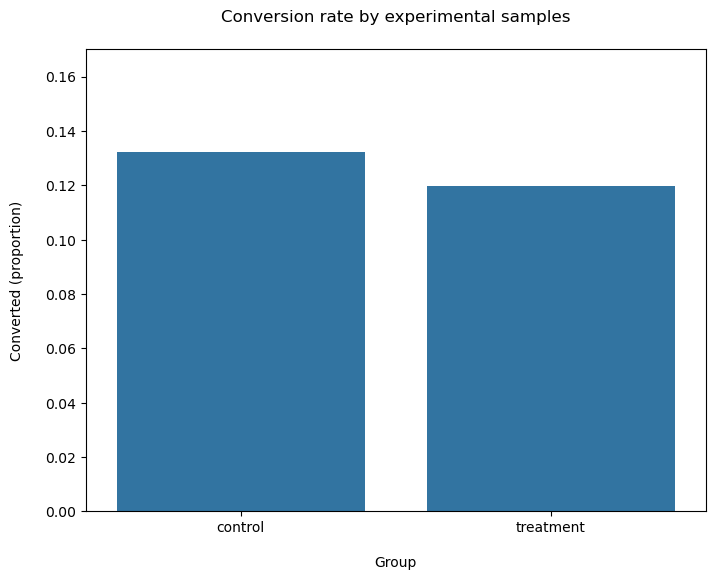

In [19]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df['group'], y=ab_df['converted'], errorbar=('ci', False));
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

4. Тестирование гипотезы

In [21]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_df[ab_df['group'] == 'control']['converted']
treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]
nobs

[4720, 4720]

In [22]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.83
p-value: 0.067
CI 95% for control group: [0.123, 0.142]
CI 95% for treatment group: [0.111, 0.129]


5. Интерпретация результатов
   p-значение = 0.067 больше, чем  альфа = 0.05, согласно статистическому выводу нет оснований отклонить нулевую гипотезу H0.
   Это означает изменения версии сервиса никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии - это случайность.
   
   Доверительный интервал для испытуемой группы [0.111, 0.129] или 11% и 12.9% соответственно:

Оне н включает наш baseline
Он не достигает нашей цели 

Таким образом:
ничего не меняем, используем старую версию (standard)   
Так как уровень конверсии 12.9%, что  близко к baseline, то в случае, если сайт воспринимается "красиво" можно его оставить, но изменения показателя конверсии изменения не принесут.  15%

2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

In [25]:
# разделяем выборку на новых и зарегистрированных пользователей
new_user_df = df[df['user_type'] == 'new_user'] #новые
reg_user_df = df[df['user_type'] == 'registered_user'] # зарегистрированные

In [26]:
# отбор пользователей - новый пользователи
new_control_sample = new_user_df[new_user_df['group'] == 'control'].sample(n = required_n, random_state=42)
new_treatment_sample = new_user_df[new_user_df['group'] == 'treatment'].sample(n = required_n, random_state=42)


In [27]:
# отбор пользователей - ранее зарегистрированные
reg_control_sample = new_user_df[new_user_df['group'] == 'control'].sample(n = required_n, random_state=42)
reg_treatment_sample = reg_user_df[reg_user_df['group'] == 'treatment'].sample(n = required_n, random_state=42)

In [28]:
# Сформируем общую случайную выборку - новые пользователи
ab_df_new = pd.concat([new_control_sample, new_treatment_sample], axis=0)
ab_df_new.reset_index(drop=True, inplace=True)
ab_df_new.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,36c2884d-9846-4553-a37f-fa36ce50cb45,2022-05-04 09:13:11.837377,control,standard,0,United Kingdom,34-41,new_user
1,58b4787c-15a1-4fc9-b1b6-a3b61e68e272,2022-05-22 14:59:41.304326,control,standard,1,United Kingdom,18-25,new_user
2,032e7ad0-0822-43c3-bb67-a96b6a52cc52,2022-05-02 17:33:23.178911,control,standard,0,United Kingdom,50-57,new_user
3,05676ce3-4498-47f3-a3f4-56fd04785318,2022-05-11 14:59:29.033575,control,standard,0,United Kingdom,34-41,new_user
4,b696f64f-f2a4-4878-9f22-c53aa82e092a,2022-05-22 05:59:01.010862,control,standard,0,United Kingdom,58+,new_user


In [29]:
# Сформируем общую случайную выборку - новые пользователи
ab_df_reg = pd.concat([reg_control_sample, reg_treatment_sample], axis=0)
ab_df_reg.reset_index(drop=True, inplace=True)
ab_df_reg.head()


,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,36c2884d-9846-4553-a37f-fa36ce50cb45,2022-05-04 09:13:11.837377,control,standard,0,United Kingdom,34-41,new_user
1,58b4787c-15a1-4fc9-b1b6-a3b61e68e272,2022-05-22 14:59:41.304326,control,standard,1,United Kingdom,18-25,new_user
2,032e7ad0-0822-43c3-bb67-a96b6a52cc52,2022-05-02 17:33:23.178911,control,standard,0,United Kingdom,50-57,new_user
3,05676ce3-4498-47f3-a3f4-56fd04785318,2022-05-11 14:59:29.033575,control,standard,0,United Kingdom,34-41,new_user
4,b696f64f-f2a4-4878-9f22-c53aa82e092a,2022-05-22 05:59:01.010862,control,standard,0,United Kingdom,58+,new_user


In [30]:
ab_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    9440 non-null   object
 1   timestamp  9440 non-null   object
 2   group      9440 non-null   object
 3   variants   9440 non-null   object
 4   converted  9440 non-null   int64 
 5   location   9440 non-null   object
 6   age_group  9440 non-null   object
 7   user_type  9440 non-null   object
dtypes: int64(1), object(7)
memory usage: 590.1+ KB


In [31]:
ab_df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    9440 non-null   object
 1   timestamp  9440 non-null   object
 2   group      9440 non-null   object
 3   variants   9440 non-null   object
 4   converted  9440 non-null   int64 
 5   location   9440 non-null   object
 6   age_group  9440 non-null   object
 7   user_type  9440 non-null   object
dtypes: int64(1), object(7)
memory usage: 590.1+ KB


In [32]:
ab_df_new.group.value_counts(normalize=True)

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

In [33]:
ab_df_reg.group.value_counts(normalize=True)

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

In [34]:
# Новые клиенты
conversion_rates = ab_df_new.groupby('group')['converted']
# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки
se_proportion = lambda x: stats.sem(x, ddof=0)
conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

C:\Users\user\AppData\Local\Temp\ipykernel_7224\3146198650.py:7: FutureWarning: The provided callable <function mean at 0x0000025C41343CE0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})


,CR mean,CR std,CR se
group,,,
control,0.122034,0.327325,0.004764
treatment,0.127331,0.333343,0.004852


Как мы видим значения метрик у испытуемой группы выше, чем у контрольной

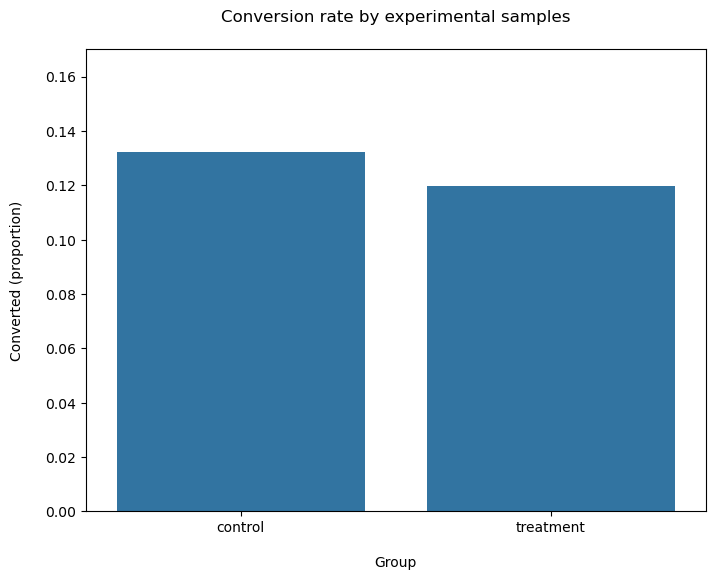

In [36]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df_new['group'], y=ab_df['converted'], errorbar=('ci', False));
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [37]:
# Старые клиенты
conversion_rates = ab_df_reg.groupby('group')['converted']
# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки
se_proportion = lambda x: stats.sem(x, ddof=0)
conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

C:\Users\user\AppData\Local\Temp\ipykernel_7224\1860385555.py:7: FutureWarning: The provided callable <function mean at 0x0000025C41343CE0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})


,CR mean,CR std,CR se
group,,,
control,0.122034,0.327325,0.004764
treatment,0.119280,0.324117,0.004718


Как мы видим значения метрик у испытуемой группы выше, чем у контрольной. CR se - на одном уровне

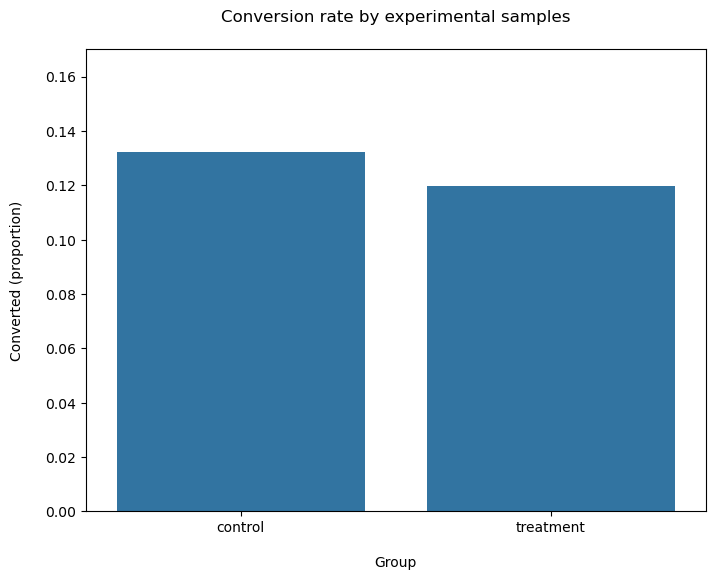

In [39]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df_reg['group'], y=ab_df['converted'], errorbar=('ci', False));
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

При визуализации видим, что удовлетворенность пользователей в разрезе новых и старых пользователей отличается не значительно

In [41]:
#новые
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results_new = ab_df_new[ab_df_new['group'] == 'control']['converted']
treatment_results_new = ab_df_new[ab_df_new['group'] == 'treatment']['converted']

n_con_new = control_results_new.count()
n_treat_new = treatment_results_new.count()
successes_new = [control_results_new.sum(), treatment_results_new.sum()]
nobs_new = [n_con_new, n_treat_new]

z_stat_new, pval_new = proportions_ztest(successes_new, nobs=nobs_new)
(lower_con_new, lower_treat_new), (upper_con_new, upper_treat_new) = proportion_confint(successes_new, nobs=nobs_new, alpha=0.05)

print(f'Z-statistic: {z_stat_new:.2f}')
print(f'p-value: {pval_new:.3f}')
print(f'CI 95% for control group: [{lower_con_new:.3f}, {upper_con_new:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat_new:.3f}, {upper_treat_new:.3f}]')

Z-statistic: -0.78
p-value: 0.436
CI 95% for control group: [0.113, 0.131]
CI 95% for treatment group: [0.118, 0.137]


Интерпретация результатов
   p-значение = 0.436 больше, чем  альфа = 0.05, согласно статистическому выводу нет оснований отклонить нулевую гипотезу H0.
   Это означает изменения версии сервиса никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии - это случайность.
   
   Доверительный интервал для испытуемой группы [0.118, 0.137] или 11.8% и 13.7% соответственно:

включает наш baseline
не достигает нашей цели 15%

Таким образом:
для новых пользователей ничего не меняем, используем старую версию (standard)

In [43]:
#зарегистрированные
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results_reg = ab_df_reg[ab_df_reg['group'] == 'control']['converted']
treatment_results_reg = ab_df_reg[ab_df_reg['group'] == 'treatment']['converted']

n_con_reg = control_results_reg.count()
n_treat_reg = treatment_results_reg.count()
successes_reg = [control_results_reg.sum(), treatment_results_reg.sum()]
nobs_reg = [n_con_reg, n_treat_reg]

z_stat_reg, pval_reg = proportions_ztest(successes_reg, nobs=nobs_reg)
(lower_con_reg, lower_treat_reg), (upper_con_reg, upper_treat_reg) = proportion_confint(successes_reg, nobs=nobs_reg, alpha=0.05)

print(f'Z-statistic: {z_stat_reg:.2f}')
print(f'p-value: {pval_reg:.3f}')
print(f'CI 95% for control group: [{lower_con_reg:.3f}, {upper_con_reg:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat_reg:.3f}, {upper_treat_reg:.3f}]')

Z-statistic: 0.41
p-value: 0.681
CI 95% for control group: [0.113, 0.131]
CI 95% for treatment group: [0.110, 0.129]


Интерпретация результатов
   p-значение = 0.681 больше, чем  альфа = 0.05, согласно статистическому выводу нет оснований отклонить нулевую гипотезу H0.
   Это означает изменения версии сервиса никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии - это случайность.
   
   Доверительный интервал для испытуемой группы [0.110, 0.129] или 11% и 12.9% соответственно:

Он не включает наш baseline
Он не достигает нашей цели 15%

Таким образом:
для зарегистрированных пользователей ничего не меняем, используем старую версию (standard) 

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

In [46]:
users = df.pivot_table(index="variants", columns="user_type", values="converted", aggfunc="sum")
users

user_type,new_user,registered_user
variants,,
standard,8935,8804
svm_ensemble_v_1_22,8609,8889


При расчете видно, что 'старая' версия сервиса предпочтительнее для новый пользователей, а новая версия сервича - для 'старых' пользователей. Но отклонения незначительные.

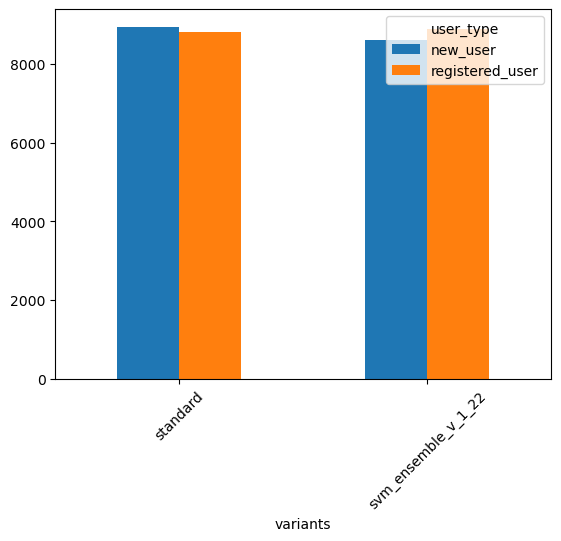

In [48]:
users.plot(kind='bar', rot=45)
plt.show()

На гистограмме видим, что 'старая' версия сервиса предпочтительнее для новый пользователей, а новая версия сервича - для 'старых' пользователей. Но отклонения незначительные.

In [50]:
age_reg = df.groupby("age_group")["user_type"].value_counts()
age_reg

age_group  user_type      
18-25      new_user           24461
           registered_user    24314
26-33      new_user           24696
           registered_user    24574
34-41      registered_user    24561
           new_user           24341
42-49      new_user           24597
           registered_user    24522
50-57      new_user           24695
           registered_user    24535
58+        registered_user    24734
           new_user           24448
Name: count, dtype: int64

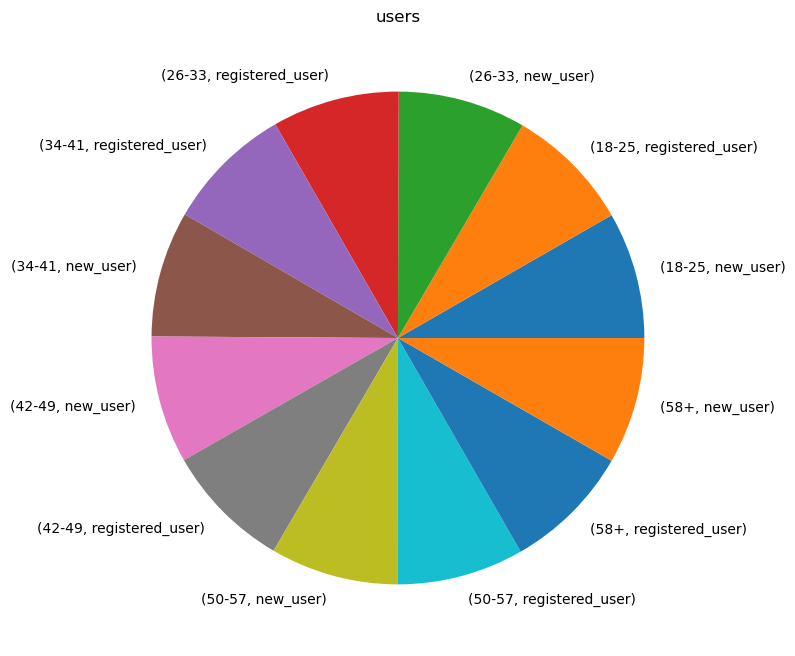

In [51]:
age_reg.plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title("users")
plt.ylabel("")
plt.show()

По диаграмме и по расчету видим, что в группах (испытуемой/контрольной) в разрезе возрастных групп количество человек отличается незначительно.
Т.е. невозможно сделать выводы какая возрастная группа, новый или старый пользователь предпочитает версию старую или новую.